<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dill, os, uproot

In [2]:
# Load real data
file = uproot.open("../Data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root")
T = file['tree']
df = T.pandas.df("v0_rxy v0_chi2 cosTheta v0_ks_mass".split(" "), entrystop = 1e5)


In [3]:
# Find outliers rought. Through five sigma away
z = (df - df.mean()) / df.std()
throw = z > 5
keep = throw.sum(axis = 1).apply(lambda x: x == 0)

df = df.loc[keep, :].reset_index(drop = True)


In [4]:
cutter_binary = dill.load(open("models/cutter_50.dat", 'rb'))
cutter = dill.loads(cutter_binary)

In [5]:
label = pd.Series(cutter(df), dtype = bool)

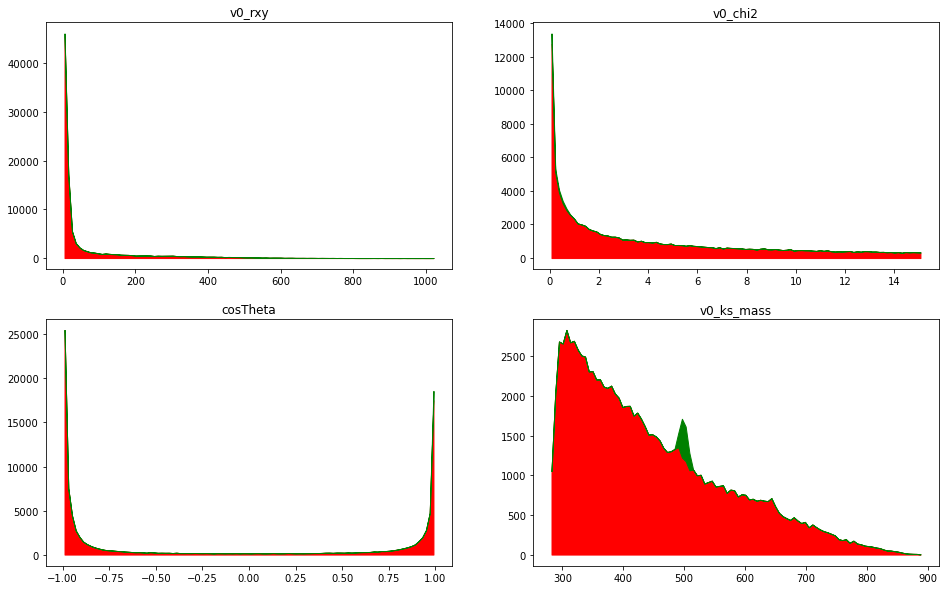

In [6]:
bins = 100

fig, ax = plt.subplots(figsize = (16, 10), ncols = 2, nrows = 2)
ax = ax.flatten()

for i, col in enumerate(df.columns):
    
    limits = (df[col].min(), df[col].max()) 
    
    true, false = df.loc[label, col], df.loc[label.apply(lambda x: not x), col]
    
    val_t, bins_t = np.histogram(true, bins = bins, range = limits)
    val_f, bins_f = np.histogram(false, bins = bins, range = limits)
    
    bins_t = 1/2*(bins_t[1:] + bins_t[:-1])
    bins_f = 1/2*(bins_f[1:] + bins_f[:-1])
    
    
    ax[i].set_title(col)
    
    ax[i].fill_between(bins_f, val_f, color = 'red')
    ax[i].fill_between(bins_t, val_t + val_f, val_f, color = 'green')

In [7]:
# Trying with the lightgbm 
df_all = T.pandas.df(entrystop = 5e5)

# Find outliers rought. Throw five sigma away
z = (df_all - df_all.mean()) / df_all.std()
throw = z > 3
keep = throw.sum(axis = 1).apply(lambda x: x == 0)

df_all = df_all.loc[keep, :].reset_index(drop = True)



cutter_binary = dill.load(open("models/MC_trained_lightgbm.dat", 'rb'))
cutter = dill.loads(cutter_binary)

In [8]:
label = pd.Series(cutter(df_all.iloc[:, :57]), dtype = bool)

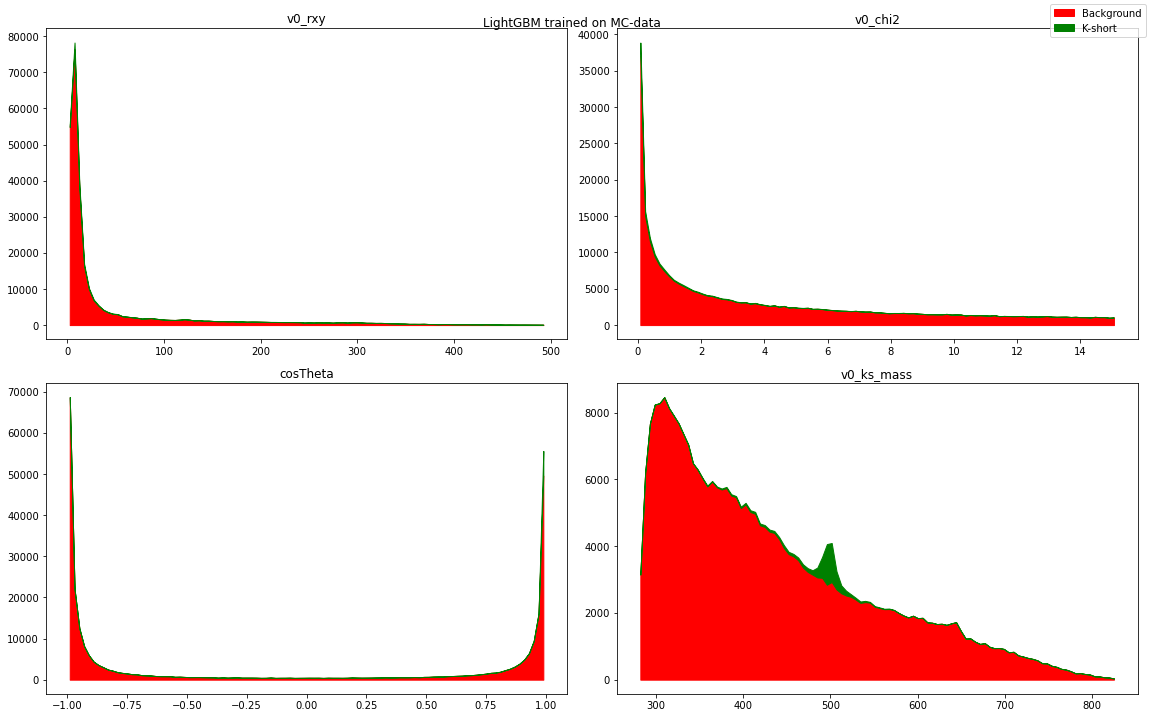

In [9]:
bins = 100

fig, ax = plt.subplots(figsize = (16, 10), ncols = 2, nrows = 2)
ax = ax.flatten()

for i, col in enumerate(df.columns):
    
    limits = (df_all[col].min(), df_all[col].max()) 
    
    true, false = df_all.loc[label, col], df_all.loc[label.apply(lambda x: not x), col]
    
    val_t, bins_t = np.histogram(true, bins = bins, range = limits)
    val_f, bins_f = np.histogram(false, bins = bins, range = limits)
    
    bins_t = 1/2*(bins_t[1:] + bins_t[:-1])
    bins_f = 1/2*(bins_f[1:] + bins_f[:-1])
    
    fig.suptitle("LightGBM trained on MC-data")
    
    ax[i].set_title(col)
    
    if i == 0:
        ax[i].fill_between(bins_f, val_f, color = 'red', label = "Background")
        ax[i].fill_between(bins_t, val_t + val_f, val_f, color = 'green', label = "K-short")
    else:
        ax[i].fill_between(bins_f, val_f, color = 'red')
        ax[i].fill_between(bins_t, val_t + val_f, val_f, color = 'green')

fig.legend(loc = 'upper right')    

fig.tight_layout()

In [10]:
ks_mass = df_all.v0_ks_mass
# ks_mass = df.v0_ks_mass

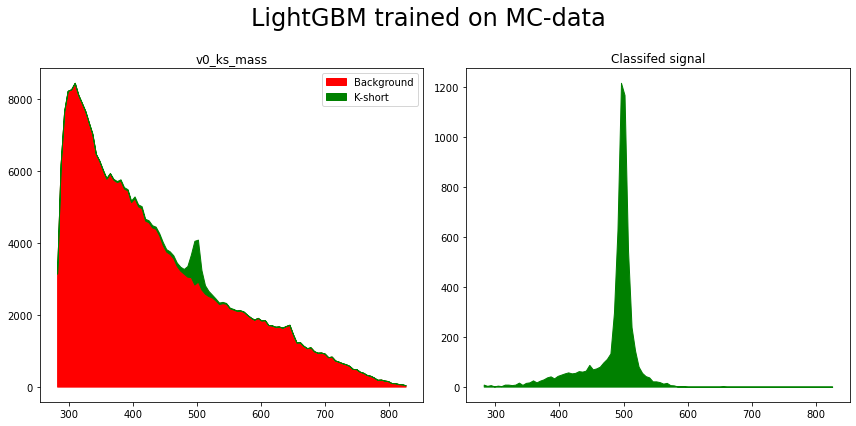

In [11]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 6))

limits = (df_all[col].min(), df_all[col].max()) 
    
true, false = ks_mass[label], ks_mass[label.apply(lambda x: not x)]

val_t, bins_t = np.histogram(true, bins = bins, range = limits)
val_f, bins_f = np.histogram(false, bins = bins, range = limits)

bins_t = 1/2*(bins_t[1:] + bins_t[:-1])
bins_f = 1/2*(bins_f[1:] + bins_f[:-1])

fig.suptitle("LightGBM trained on MC-data", fontsize = 24)

ax[0].set_title('v0_ks_mass')

ax[0].fill_between(bins_f, val_f, color = 'red', label = "Background")
ax[0].fill_between(bins_t, val_t + val_f, val_f, color = 'green', label = "K-short")


ax[1].set_title("Classifed signal")
ax[1].fill_between(bins_t, val_t, color = "green")

ax[0].legend(loc = "upper right")

fig.tight_layout(rect = (0, 0, 1, 0.9))


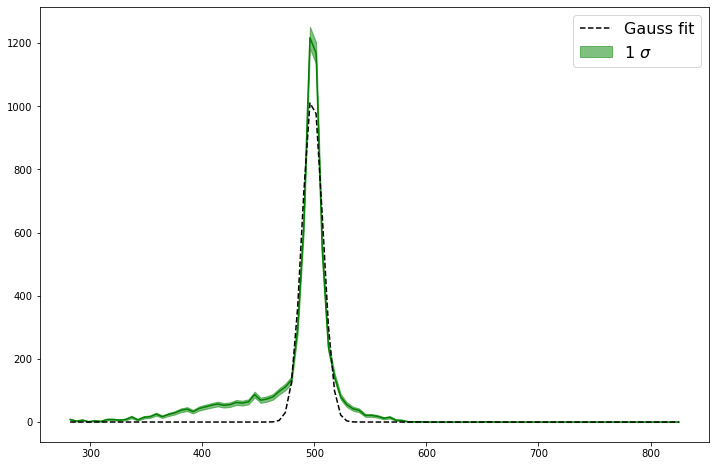

In [12]:
# lets try to fit the signal and background. We expect signal to be gaussian distributed, so lets try
# that with a chi2 fit
from iminuit import Minuit
from ExternalFunctions import Chi2Regression

fig_sig, ax_sig = plt.subplots(figsize = (12, 8))

errs = np.sqrt(val_t)

ax_sig.plot(bins_t, val_t, 'g-')
ax_sig.fill_between(bins_t, val_t + errs, val_t - errs, color = 'g', alpha = 0.5, label = '1 $\sigma$')

mask = val_t > 0


from scipy.stats import norm
from scipy.optimize import curve_fit

def fitfunc(x, N, mu, sigma):
    return N * norm.pdf(x, mu, sigma)

N, mu, sigma = curve_fit(fitfunc, bins_t[mask], val_t[mask], p0 = [1e5, 500, 10])[0]

chi2_obj = Chi2Regression(fitfunc, bins_t[mask], val_t[mask], errs[mask])
chi2_min = Minuit(chi2_obj, pedantic = False, mu = mu, N = N, sigma = sigma)
chi2_min.migrad()

ax_sig.plot(bins_t, fitfunc(bins_t, *chi2_min.args), 'k--', label = "Gauss fit")

# def fitfunc_2_norms(x, N, f, mu, sigma_1, sigma_2):
#     return fitfunc(x, N * f, mu, sigma_1) + fitfunc(x, (1 - f) * N, mu, sigma_2)

# N, f, mu, sigma_1, sigma_2 = curve_fit(fitfunc_2_norms, bins_t[mask], val_t[mask], p0 = [1e5, 0.75, 500, 10, 25])[0]

# chi2_obj = Chi2Regression(fitfunc_2_norms, bins_t[mask], val_t[mask], errs[mask])
# chi2_min = Minuit(chi2_obj, pedantic = False, mu = mu, N = N, sigma_1 = sigma_1, f = f, sigma_2 = sigma_2)
# chi2_min.migrad()

# ax_sig.plot(bins_t, fitfunc_2_norms(bins_t, *chi2_min.args), '--', label = "2 Gauss fit", color = "orange")

ax_sig.legend(loc = 'upper right', prop = {'size': 16})

In [ ]:
import shap

# Skræl løsing
scalers = dill.loads(b'\x80\x03}q\x00(X\x0c\x00\x00\x00eventCounterq\x01]q\x02(G@\xb5\xa1\x84\xfa\xac\xd9\xe8G@\xa9\'\xd3\xfe:|3eX\x03\x00\x00\x00npvq\x03]q\x04(G?\xf0,\xa5zxl"G?\xbc\xf1I\x8a\xe3\x18\xb6eX\x08\x00\x00\x00ntrk_pv0q\x05]q\x06(G@L\xa3\xaf\xb7\xe9\x0f\xf9G@;\x1d\xef\x8ac\xf2\x1deX\x05\x00\x00\x00pv0_xq\x07]q\x08(G\xbfPz;\xa0\x00\x00\x00G?\xb0\xd7\xbc`\x00\x00\x00eX\x05\x00\x00\x00pv0_yq\t]q\n(G\xbfL\xd9-\x80\x00\x00\x00G?\xb0\xd7y`\x00\x00\x00eX\x05\x00\x00\x00pv0_zq\x0b]q\x0c(G?\xc1\xd1\x01\xe0\x00\x00\x00G@P\xab\xa7\xc0\x00\x00\x00eX\x04\x00\x00\x00a0xyq\r]q\x0e(G@\n!\xa7\x00\x00\x00\x00G@(!\xd6\x80\x00\x00\x00eX\x02\x00\x00\x00a0q\x0f]q\x10(G@\x1f\xe4$\xa0\x00\x00\x00G@7E\xa2`\x00\x00\x00eX\x03\x00\x00\x00a0zq\x11]q\x12(G@\x1f\xe4$\xa0\x00\x00\x00G@7E\xa2`\x00\x00\x00eX\x08\x00\x00\x00cosThetaq\x13]q\x14(G?\xc5&(`\x00\x00\x00G?\xea\xb2\xef\xa0\x00\x00\x00eX\x07\x00\x00\x00v0_chi2q\x15]q\x16(G@\rd\xbe\xe0\x00\x00\x00G@\x100\x88\xa0\x00\x00\x00eX\x04\x00\x00\x00v0_xq\x17]q\x18(G?\xd3x\xa2\x00\x00\x00\x00G@O\xe0\x9b\xa0\x00\x00\x00eX\x04\x00\x00\x00v0_yq\x19]q\x1a(G?\xd6[\xec@\x00\x00\x00G@M\xe6\xc7\xe0\x00\x00\x00eX\x04\x00\x00\x00v0_zq\x1b]q\x1c(G\xbf\xf4\x92\x00\xa0\x00\x00\x00G@hWs \x00\x00\x00eX\x06\x00\x00\x00v0_rxyq\x1d]q\x1e(G@;\x01\xdb \x00\x00\x00G@T\xc8\xe1\x80\x00\x00\x00eX\t\x00\x00\x00v0_rxyErrq\x1f]q (G@\x05\xa1G\xa0\x00\x00\x00G@ \x02_\x80\x00\x00\x00eX\x05\x00\x00\x00v0_pxq!]q"(G?\xfe`K \x00\x00\x00G@\x85\x95\x1f`\x00\x00\x00eX\x05\x00\x00\x00v0_pyq#]q$(G\xc0$\x13\x93\xe0\x00\x00\x00G@\x87"!@\x00\x00\x00eX\x05\x00\x00\x00v0_pzq%]q&(G@D\x0fl\x80\x00\x00\x00G@\xa6^\t\xc0\x00\x00\x00eX\x05\x00\x00\x00v0_ptq\']q((G@\x86J\x15\xe0\x00\x00\x00G@\x86tl \x00\x00\x00eX\x04\x00\x00\x00v0_pq)]q*(G@\x9f{\xa8 \x00\x00\x00G@\xa1\xc0\xa7\xa0\x00\x00\x00eX\x08\x00\x00\x00v0_ptErrq+]q,(G@0d\x04\x00\x00\x00\x00G@F\x88R\xe0\x00\x00\x00eX\n\x00\x00\x00v0_ks_massq-]q.(G@\x7f\xf2R\xc0\x00\x00\x00G@`b2\xe0\x00\x00\x00eX\n\x00\x00\x00v0_la_massq/]q0(G@\x96\x17\x92@\x00\x00\x00G@tS\x02`\x00\x00\x00eX\n\x00\x00\x00v0_lb_massq1]q2(G@\x95\x8ba\xc0\x00\x00\x00G@r\x80\xf7`\x00\x00\x00eX\r\x00\x00\x00v0_ks_massErrq3]q4(G@)O1\xa0\x00\x00\x00G@$\xf3R@\x00\x00\x00eX\r\x00\x00\x00v0_la_massErrq5]q6(G@2\xa4+\xe0\x00\x00\x00G@9\xf4\x8c\xc0\x00\x00\x00eX\r\x00\x00\x00v0_lb_massErrq7]q8(G@1\\M\xe0\x00\x00\x00G@9?\x11\xe0\x00\x00\x00eX\x06\x00\x00\x00v0_px1q9]q:(G?\xe3\x9d\x01`\x00\x00\x00G@y\x1fM\x80\x00\x00\x00eX\x06\x00\x00\x00v0_py1q;]q<(G\xc0\x15\x1du \x00\x00\x00G@{\xf6\xdd\xe0\x00\x00\x00eX\x06\x00\x00\x00v0_pz1q=]q>(G@=\x05D\xa0\x00\x00\x00G@\x9aMX \x00\x00\x00eX\x06\x00\x00\x00v0_pt1q?]q@(G@xO\x90\xc0\x00\x00\x00G@|\xac\x8b@\x00\x00\x00eX\x05\x00\x00\x00v0_p1qA]qB(G@\x8fG:`\x00\x00\x00G@\x97%d\xa0\x00\x00\x00eX\x06\x00\x00\x00v0_px2qC]qD(G?\xf4\x91\xd6\xc0\x00\x00\x00G@z\xda\\\x00\x00\x00\x00eX\x06\x00\x00\x00v0_py2qE]qF(G\xc0\x13\t\xaf@\x00\x00\x00G@{\xb17\xa0\x00\x00\x00eX\x06\x00\x00\x00v0_pz2qG]qH(G@&3\x19\x00\x00\x00\x00G@\x9a\xa0y\x80\x00\x00\x00eX\x06\x00\x00\x00v0_pt2qI]qJ(G@z3\xf9`\x00\x00\x00G@|O\x1c\x00\x00\x00\x00eX\x05\x00\x00\x00v0_p2qK]qL(G@\x91\x00C\xa0\x00\x00\x00G@\x96\xa6"\x80\x00\x00\x00eX\x07\x00\x00\x00v0_phi1qM]qN(G\xbf\x9a\x1e\x1d\x80\x00\x00\x00G?\xfc\xea\xc5\xc0\x00\x00\x00eX\t\x00\x00\x00v0_theta1qO]qP(G?\xf9\x05\xe7\x00\x00\x00\x00G?\xf0\x80-`\x00\x00\x00eX\n\x00\x00\x00v0_qOverP1qQ]qR(G?bh\x8d\xe0\x00\x00\x00G?]z\xe5\xe0\x00\x00\x00eX\x07\x00\x00\x00v0_phi2qS]qT(G\xbf\x90\xef\xc3`\x00\x00\x00G?\xfd\x0f\\\xe0\x00\x00\x00eX\t\x00\x00\x00v0_theta2qU]qV(G?\xf9\x05\xe7\x00\x00\x00\x00G?\xf0\x80-`\x00\x00\x00eX\n\x00\x00\x00v0_qOverP2qW]qX(G\xbf`O\xe0 \x00\x00\x00G?Yb\xe6 \x00\x00\x00eX\x05\x00\x00\x00alphaqY]qZ(G\xbf\xae\xe1\xf8\x00\x00\x00\x00G?\xf0\x80i\xa0\x00\x00\x00eX\x06\x00\x00\x00calphaq[]q\\(G?\xe4F \x80\x00\x00\x00G?\xdd\x975 \x00\x00\x00eX\x08\x00\x00\x00epsilon1q]]q^(G?\xe2\xa5\x01\xa0\x00\x00\x00G?\xf2\xd2\xd5@\x00\x00\x00eX\x08\x00\x00\x00epsilon2q_]q`(G?\xe3\xec\xcb\xa0\x00\x00\x00G?\xf3\x1aM\x00\x00\x00\x00eX\x05\x00\x00\x00Alphaqa]qb(G\xbf\xae\xe1\xf7\xc0\x00\x00\x00G?\xf0\x80i@\x00\x00\x00eX\x03\x00\x00\x00pL1qc]qd(G@\x8e\x0b\xcf@\x00\x00\x00G@\x97go`\x00\x00\x00eX\x03\x00\x00\x00pL2qe]qf(G@\x90u\xc5\xc0\x00\x00\x00G@\x96\xe57\xe0\x00\x00\x00eX\x02\x00\x00\x00pTqg]qh(G@cO\xf3`\x00\x00\x00G@Pg\xca@\x00\x00\x00eX\t\x00\x00\x00thetastarqi]qj(G?\xfa\x1d\x1d\xe0\x00\x00\x00G?\xe7\x06\x82\x00\x00\x00\x00eX\x0b\x00\x00\x00rapidity_ksqk]ql(G?\x81\xb2\xcc\x00\x00\x00\x00G?\xf5\xeb\xc4@\x00\x00\x00eX\x0b\x00\x00\x00rapidity_laqm]qn(G?}\xb6\x19\xc0\x00\x00\x00G?\xed\x8a\x03 \x00\x00\x00eX\x0b\x00\x00\x00rapidity_lbqo]qp(G?|&}\xc0\x00\x00\x00G?\xed\xee\x1e`\x00\x00\x00eX\x0e\x00\x00\x00pseudorapidityqq]qr(G?\x82\xba\x18 \x00\x00\x00G?\xfc\xa7\xa9\xa0\x00\x00\x00eu.')


df = df_all.iloc[:, :57]

df_all_norm = pd.DataFrame(None)
for col in df_all.columns[:57]:
    if df[col].std() != 0:
        df_all_norm[col] = (df[col] - scalers[col][0]) / scalers[col][1]

cutter_binary = dill.load(open("models/MC_trained_lightGBM_whole.dat", 'rb'))
model = dill.loads(cutter_binary)          

expl = shap.TreeExplainer(model, df_all_norm)

Passing 297047 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.
